<a href="https://colab.research.google.com/github/diegomrodrigues/generative_models_experiments/blob/main/NADE%20and%20FVSBN%20Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Epoch 0, Loss: 1.3863
Epoch 500, Loss: 1.2275
Epoch 1000, Loss: 1.2274
Epoch 1500, Loss: 1.2274
Epoch 2000, Loss: 1.2273
Epoch 2500, Loss: 1.2272
Epoch 3000, Loss: 1.2272
Epoch 3500, Loss: 1.2271
Epoch 4000, Loss: 1.2271
Epoch 4500, Loss: 1.2270
Epoch 5000, Loss: 1.2270
Epoch 5500, Loss: 1.2267
Epoch 6000, Loss: 1.2257
Epoch 6500, Loss: 1.2211
Epoch 7000, Loss: 1.2192
Epoch 7500, Loss: 1.2173
Epoch 8000, Loss: 1.2156
Epoch 8500, Loss: 1.2145
Epoch 9000, Loss: 1.2134
Epoch 9500, Loss: 1.2123
Epoch 10000, Loss: 1.2108
Epoch 10500, Loss: 1.2092
Epoch 11000, Loss: 1.2074
Epoch 11500, Loss: 1.2055
Epoch 12000, Loss: 1.2036
Epoch 12500, Loss: 1.2018
Epoch 13000, Loss: 1.2001
Epoch 13500, Loss: 1.1986
Epoch 14000, Loss: 1.1974
Epoch 14500, Loss: 1.1964
Epoch 15000, Loss: 1.1956
Epoch 15500, Loss: 1.1950
Epoch 16000, Loss: 1.1944
Epoch 16500, Loss: 1.1940
Epoch 17000, Loss: 1.1936
Epoch 17500, Loss: 1.1933
Epoch 18000, Loss: 1.1930
Epoch 18500, Loss: 1.1926
Epoch 19000, Loss

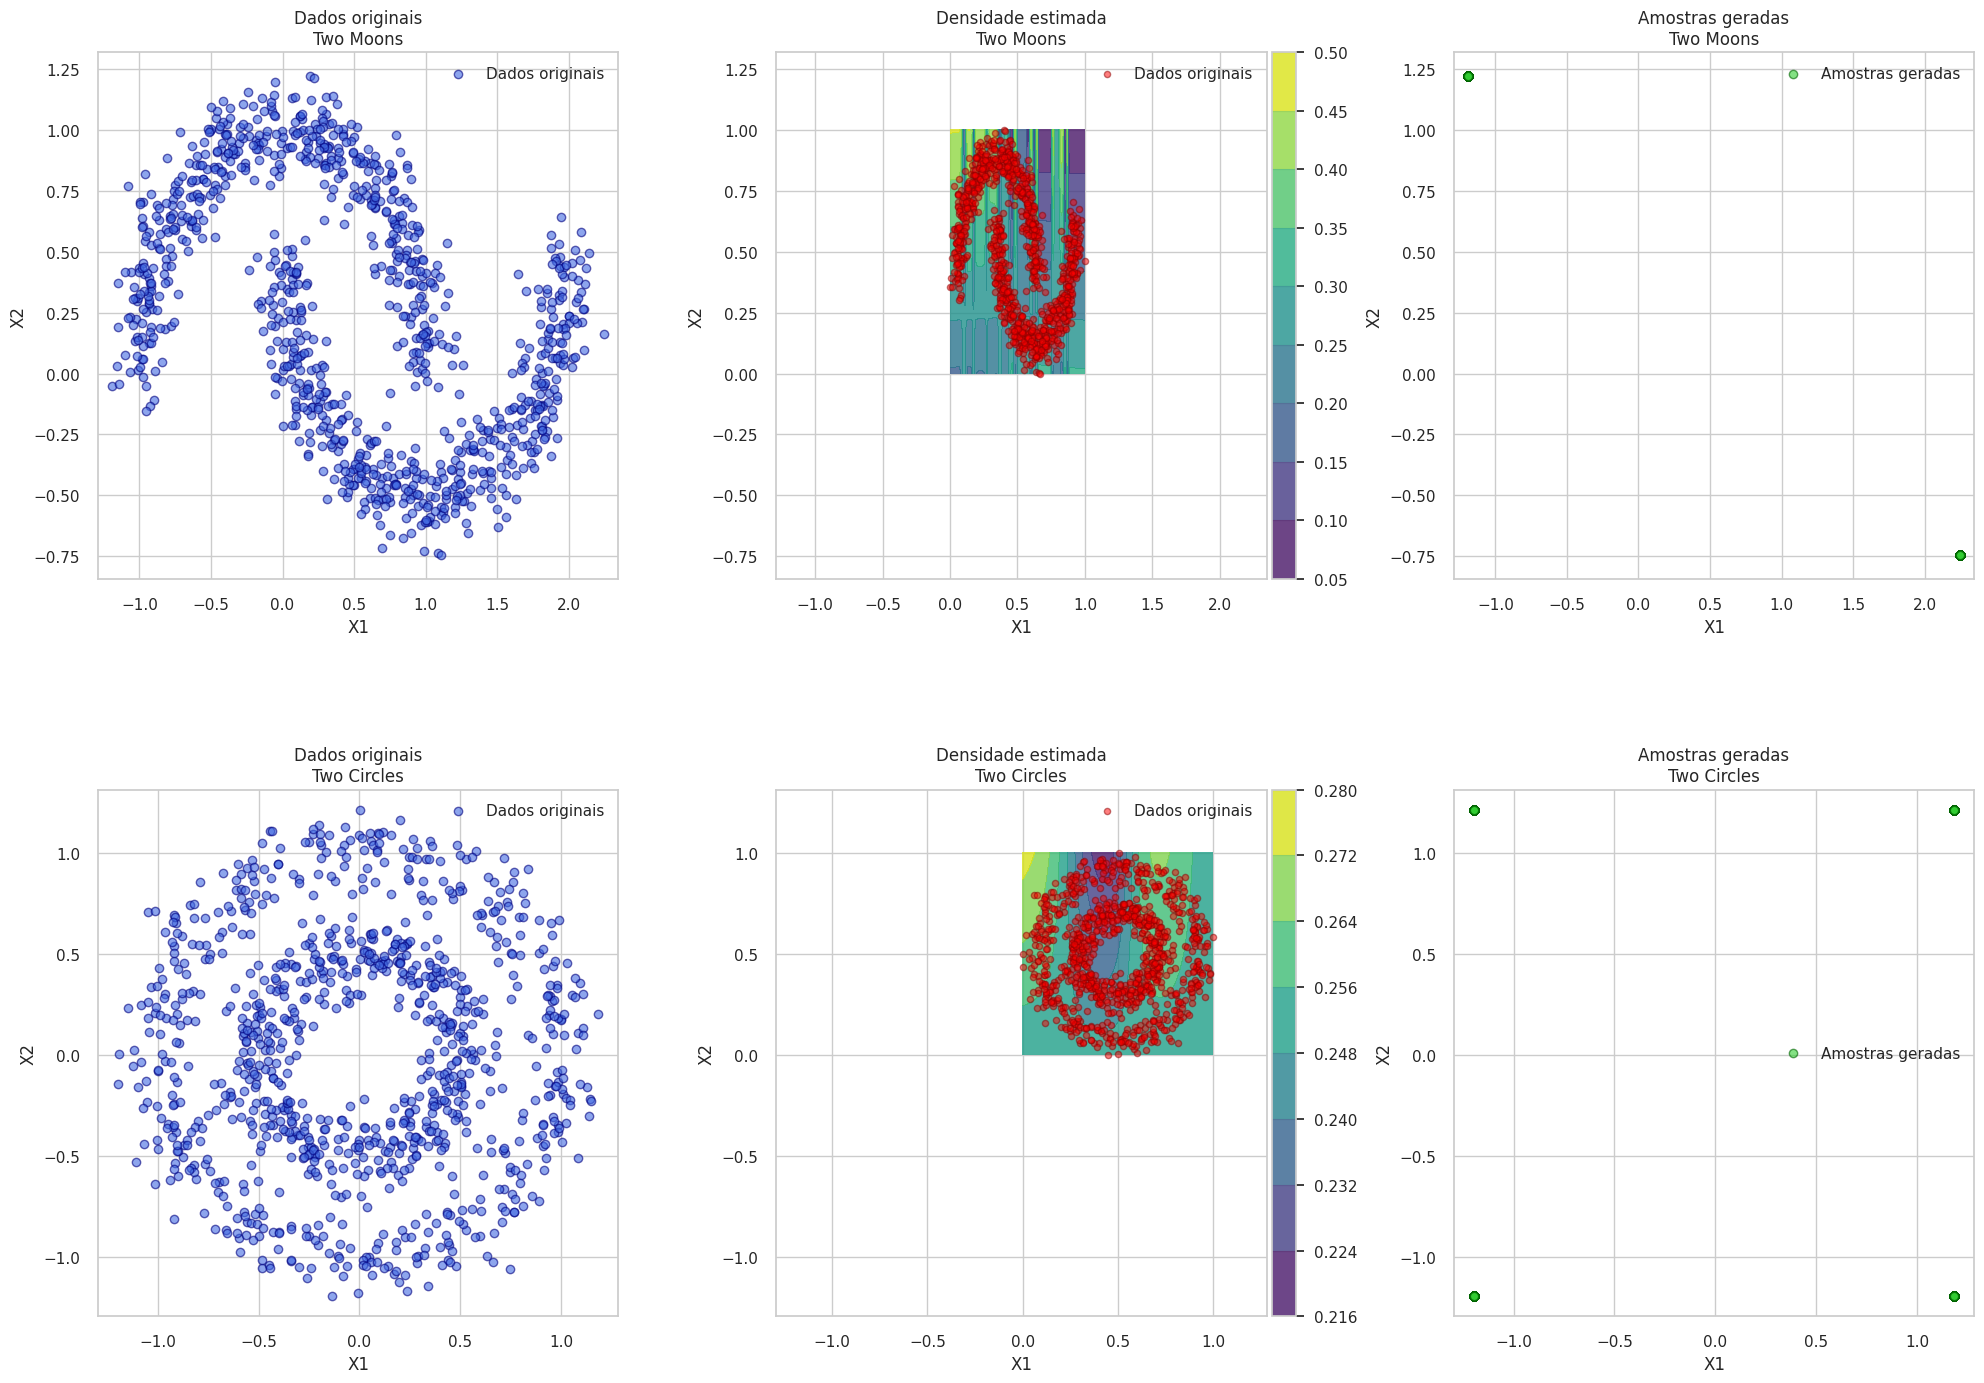

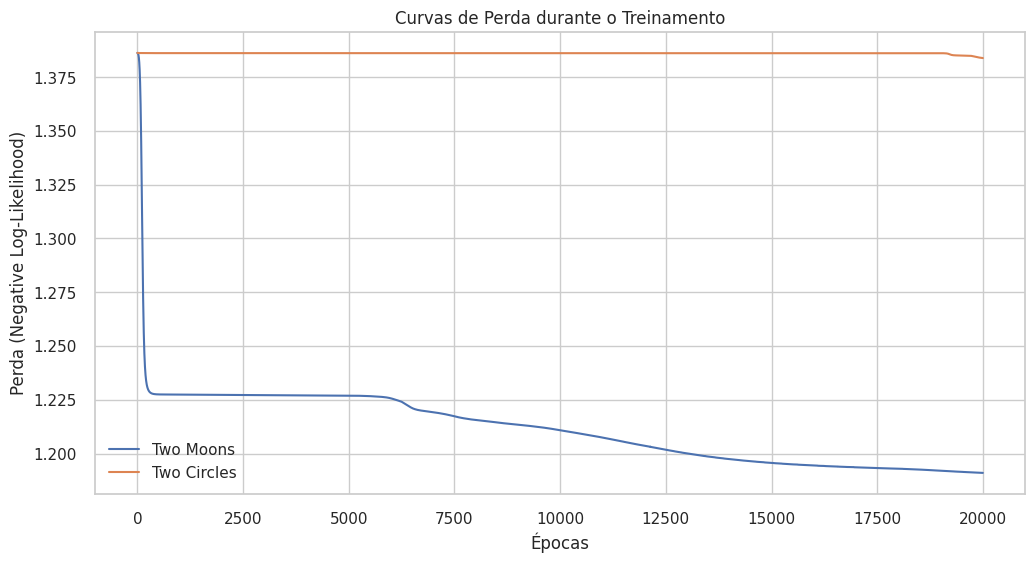

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons, make_circles
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Configurações do plot
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [20, 14]
plt.rcParams['font.size'] = 12

# Verificar se GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Classe NADE melhorada
class ImprovedNADE(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2):
        super(ImprovedNADE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2

        self.W1 = nn.Parameter(torch.randn(hidden_dim1, input_dim, device=device) * 0.01)
        self.b1 = nn.Parameter(torch.zeros(hidden_dim1, device=device))
        self.W2 = nn.Parameter(torch.randn(hidden_dim2, hidden_dim1, device=device) * 0.01)
        self.b2 = nn.Parameter(torch.zeros(hidden_dim2, device=device))
        self.V = nn.Parameter(torch.randn(input_dim, hidden_dim2, device=device) * 0.01)
        self.c = nn.Parameter(torch.zeros(input_dim, device=device))

    def forward(self, x):
        batch_size = x.shape[0]
        log_probs = torch.zeros(batch_size, self.input_dim, device=device)

        for i in range(self.input_dim):
            h1 = torch.tanh(torch.mm(x[:, :i], self.W1[:, :i].t()) + self.b1)
            h2 = torch.tanh(torch.mm(h1, self.W2.t()) + self.b2)
            o = torch.sigmoid(torch.mm(h2, self.V[i, :].unsqueeze(1)) + self.c[i]).squeeze()
            log_probs[:, i] = torch.log(o * x[:, i] + (1 - o) * (1 - x[:, i]) + 1e-8)

        return log_probs.sum(dim=1)

    def sample(self, num_samples=1):
        with torch.no_grad():
            samples = torch.zeros(num_samples, self.input_dim, device=device)

            for i in range(self.input_dim):
                h1 = torch.tanh(torch.mm(samples[:, :i], self.W1[:, :i].t()) + self.b1)
                h2 = torch.tanh(torch.mm(h1, self.W2.t()) + self.b2)
                o = torch.sigmoid(torch.mm(h2, self.V[i, :].unsqueeze(1)) + self.c[i]).squeeze()
                samples[:, i] = torch.bernoulli(o)

            return samples.cpu().numpy()

# Função para treinar o modelo NADE
def train_nade(model, data, epochs=5000, lr=0.0005):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        log_likelihood = model(data).mean()
        loss = -log_likelihood
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()
        losses.append(loss.item())

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    return losses

# Função para calcular a densidade estimada
def calculate_density(model, X, scaler):
    xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
    positions = np.vstack([xx.ravel(), yy.ravel()]).T
    positions_scaled = scaler.transform(positions)
    with torch.no_grad():
        density = np.exp(model(torch.FloatTensor(positions_scaled).to(device)).cpu().numpy()).reshape(xx.shape)
    return density

# Função para plotar com melhorias
def plot_improved(X_original, X_scaled, samples, density, scaler, title, ax_row):
    # Dados originais
    ax_row[0].scatter(X_original[:, 0], X_original[:, 1], alpha=0.6, c='royalblue', edgecolors='navy', label='Dados originais')
    ax_row[0].set_title(f"Dados originais\n{title}")
    ax_row[0].legend()
    ax_row[0].set_xlabel('X1')
    ax_row[0].set_ylabel('X2')

    # Densidade estimada
    xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
    im = ax_row[1].contourf(xx, yy, density, cmap='viridis', alpha=0.8)
    ax_row[1].scatter(X_scaled[:, 0], X_scaled[:, 1], c='red', alpha=0.5, edgecolors='darkred', s=20, label='Dados originais')
    ax_row[1].set_title(f"Densidade estimada\n{title}")
    ax_row[1].legend()
    ax_row[1].set_xlabel('X1')
    ax_row[1].set_ylabel('X2')

    # Adicionar barra de cores
    divider = make_axes_locatable(ax_row[1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    # Amostras geradas
    ax_row[2].scatter(samples[:, 0], samples[:, 1], alpha=0.6, c='limegreen', edgecolors='darkgreen', label='Amostras geradas')
    ax_row[2].set_title(f"Amostras geradas\n{title}")
    ax_row[2].legend()
    ax_row[2].set_xlabel('X1')
    ax_row[2].set_ylabel('X2')

    # Ajustar limites dos eixos
    for ax in ax_row:
        ax.set_xlim(X_original[:, 0].min() - 0.1, X_original[:, 0].max() + 0.1)
        ax.set_ylim(X_original[:, 1].min() - 0.1, X_original[:, 1].max() + 0.1)

# Gerar dados
n_samples = 1000
X_moons, _ = make_moons(n_samples=n_samples, noise=0.1)
X_circles, _ = make_circles(n_samples=n_samples, noise=0.1, factor=0.5)

# Normalizar os dados
scaler_moons = MinMaxScaler()
scaler_circles = MinMaxScaler()
X_moons_scaled = scaler_moons.fit_transform(X_moons)
X_circles_scaled = scaler_circles.fit_transform(X_circles)

# Converter para tensores e mover para GPU
X_moons_tensor = torch.FloatTensor(X_moons_scaled).to(device)
X_circles_tensor = torch.FloatTensor(X_circles_scaled).to(device)

# Treinar modelos NADE
nade_moons = ImprovedNADE(input_dim=2, hidden_dim1=100, hidden_dim2=50).to(device)
nade_circles = ImprovedNADE(input_dim=2, hidden_dim1=100, hidden_dim2=50).to(device)

losses_moons = train_nade(nade_moons, X_moons_tensor, epochs=20000)
losses_circles = train_nade(nade_circles, X_circles_tensor, epochs=20000)

# Calcular densidades
density_moons = calculate_density(nade_moons, X_moons_scaled, scaler_moons)
density_circles = calculate_density(nade_circles, X_circles_scaled, scaler_circles)

# Gerar amostras
samples_moons = scaler_moons.inverse_transform(nade_moons.sample(5000))
samples_circles = scaler_circles.inverse_transform(nade_circles.sample(5000))

# Plotar resultados
fig, axs = plt.subplots(2, 3, figsize=(20, 14))

plot_improved(X_moons, X_moons_scaled, samples_moons, density_moons, scaler_moons, "Two Moons", axs[0])
plot_improved(X_circles, X_circles_scaled, samples_circles, density_circles, scaler_circles, "Two Circles", axs[1])

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

# Plotar curvas de perda
plt.figure(figsize=(12, 6))
plt.plot(losses_moons, label='Two Moons')
plt.plot(losses_circles, label='Two Circles')
plt.title("Curvas de Perda durante o Treinamento")
plt.xlabel("Épocas")
plt.ylabel("Perda (Negative Log-Likelihood)")
plt.legend()
plt.show()

<ipython-input-16-b977db0e3cd7>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Usando dispositivo: cuda


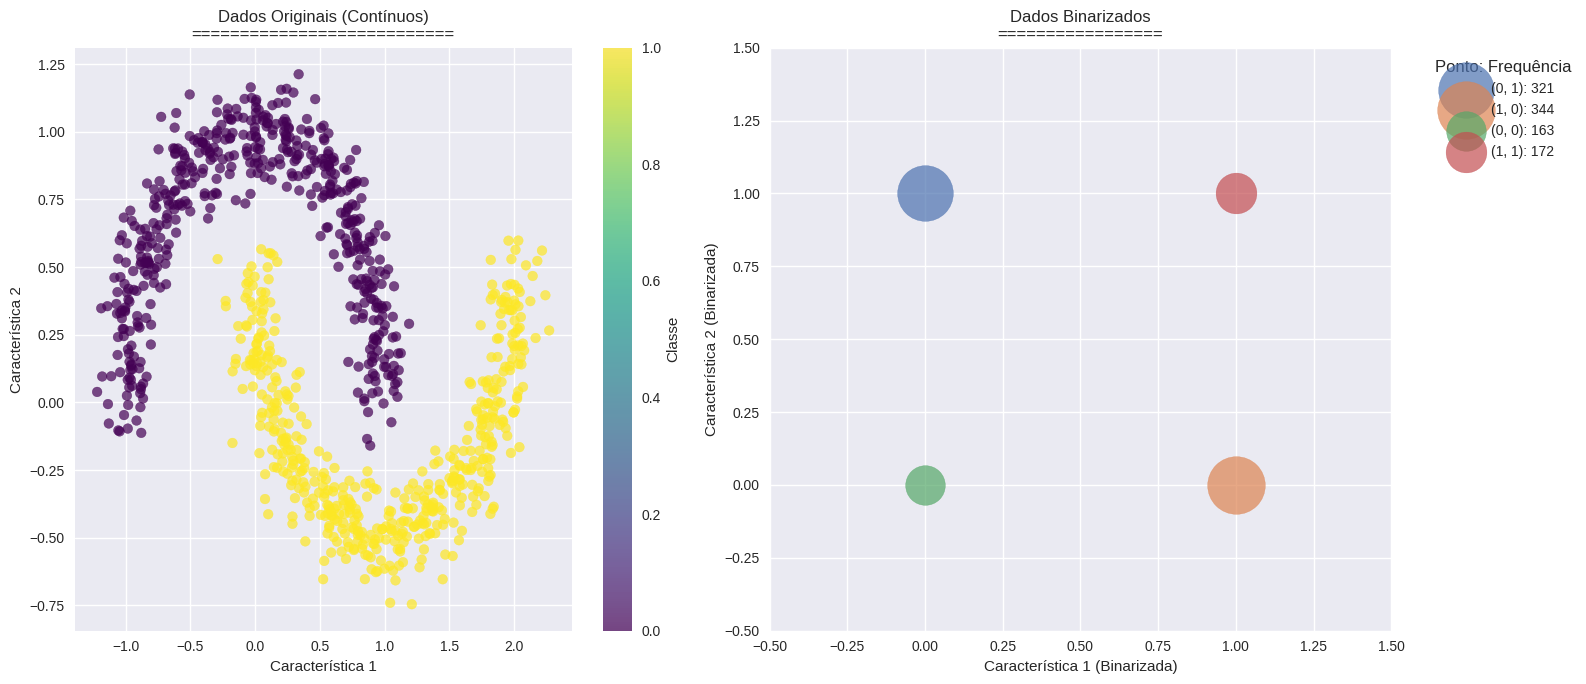

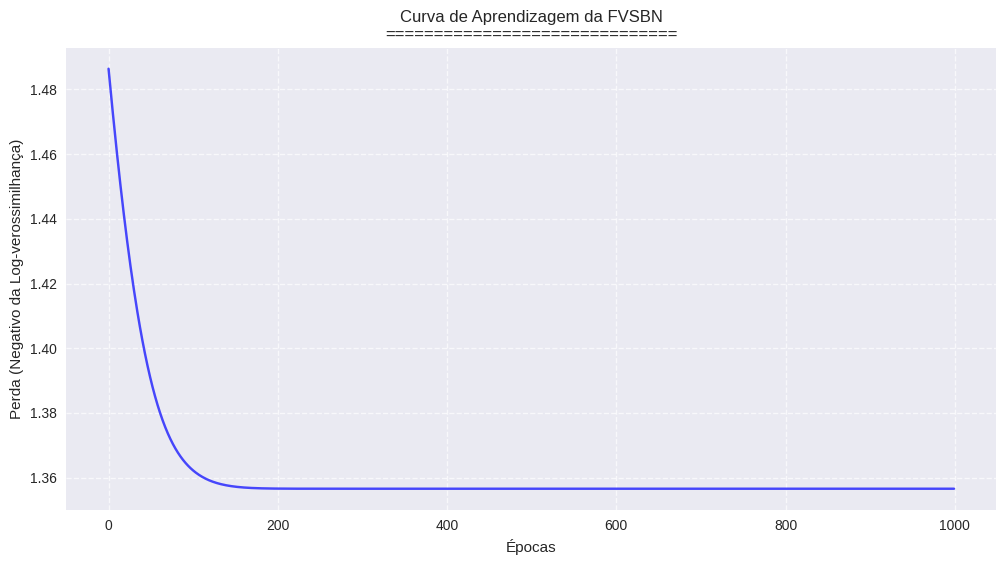

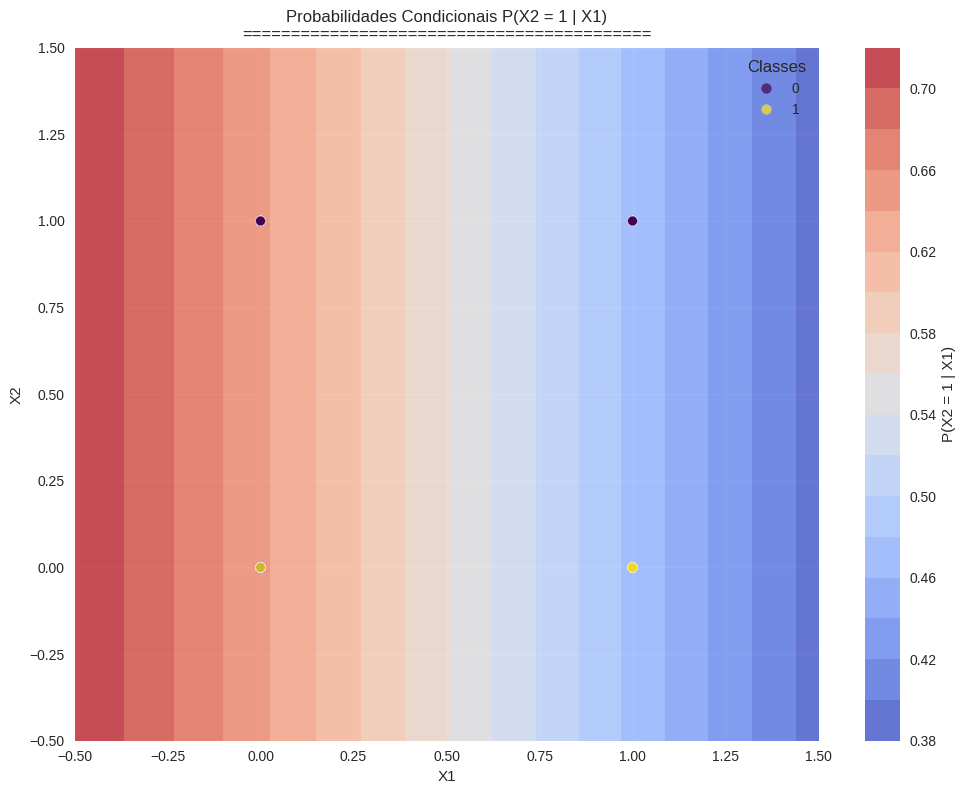

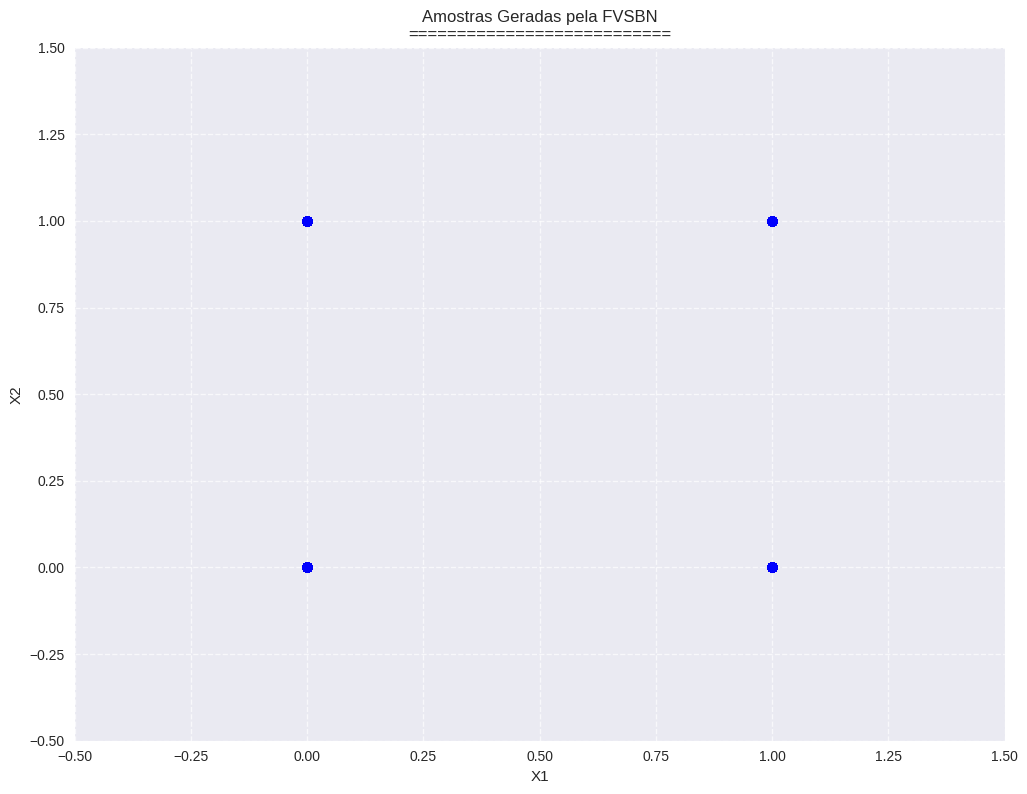

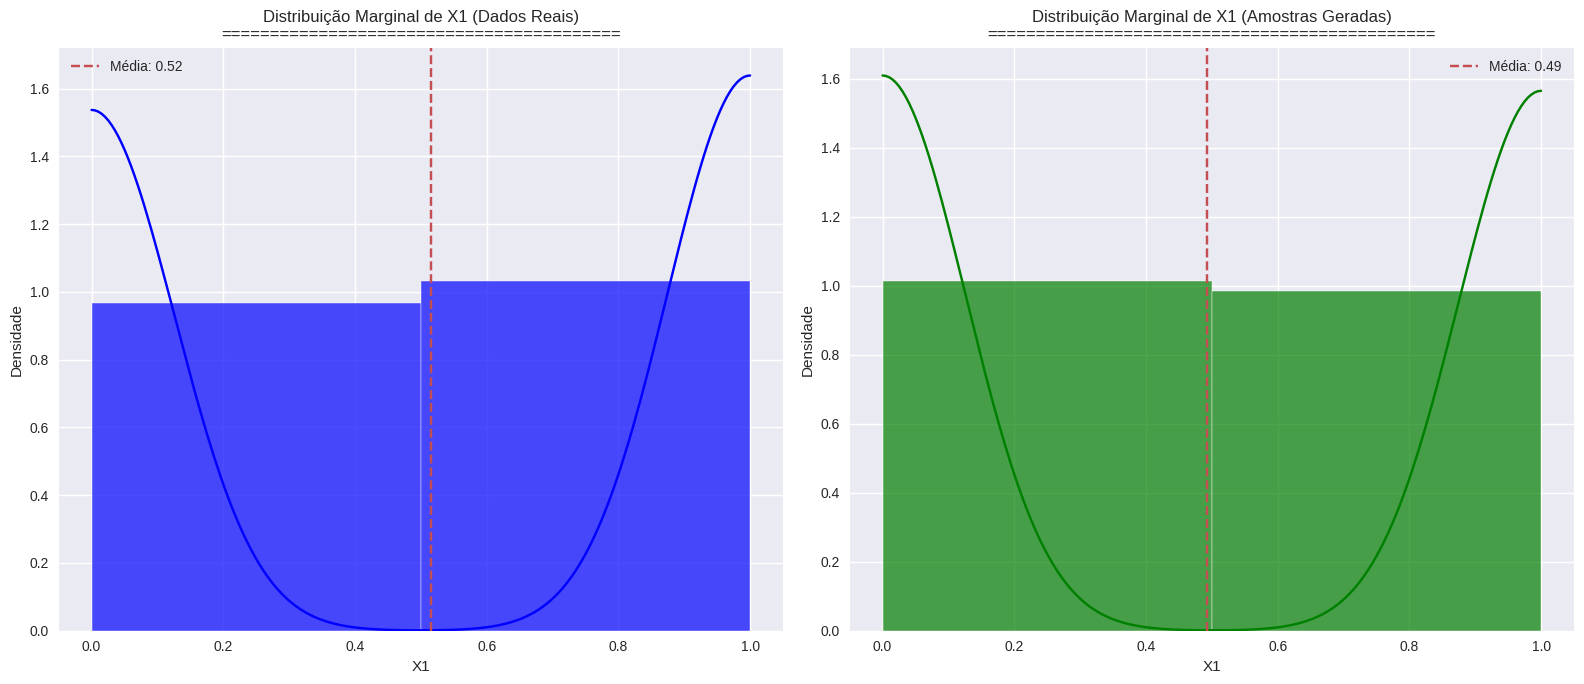

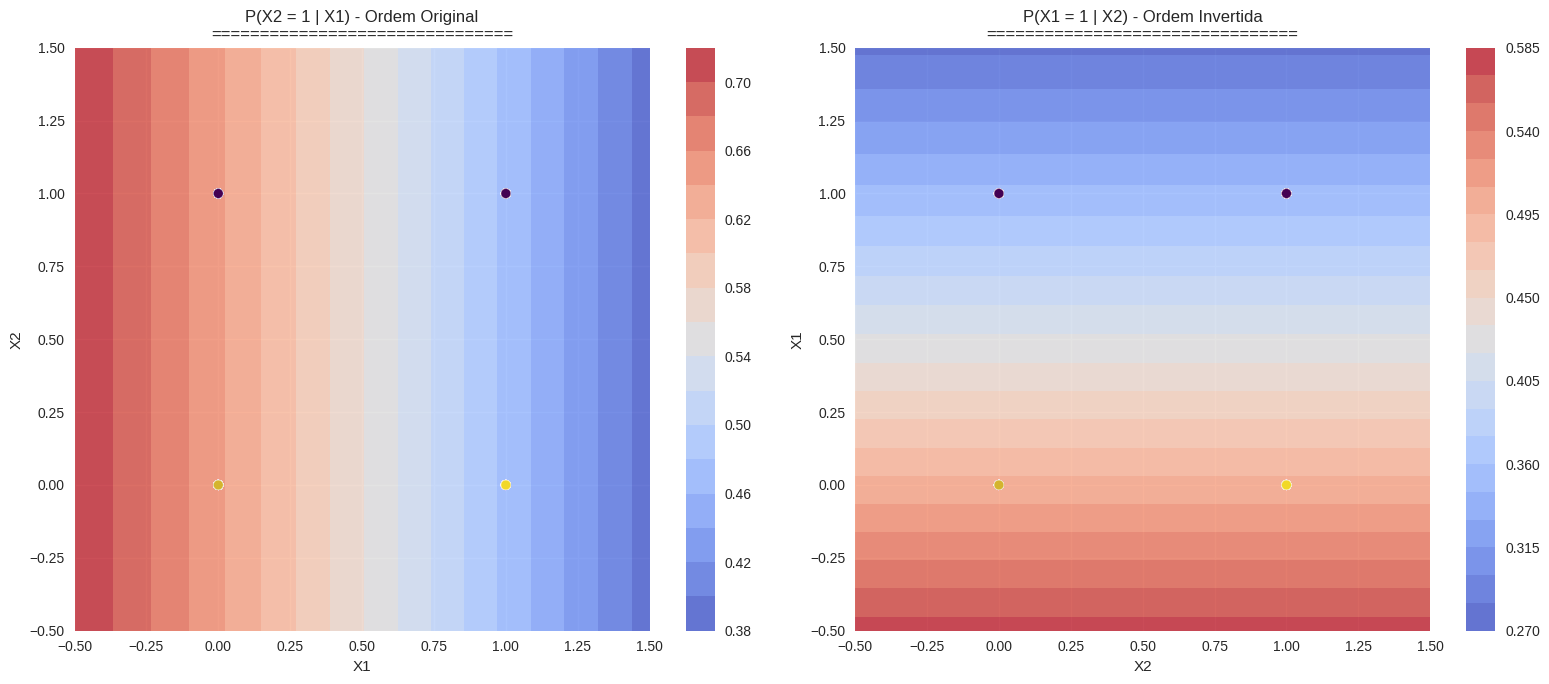

Explicação dos gráficos:

1. Dados Originais vs. Binarizados:
   - O gráfico da esquerda mostra os dados contínuos originais em forma de duas luas.
   - O gráfico da direita mostra os dados após a binarização, com apenas 4 pontos possíveis.
   - O tamanho dos pontos no gráfico binarizado representa a frequência de cada combinação.

2. Curva de Aprendizagem:
   - Mostra como a perda (negativo da log-verossimilhança) diminui ao longo das épocas de treinamento.
   - Uma curva descendente indica que o modelo está aprendendo a distribuição dos dados.

3. Probabilidades Condicionais:
   - Visualiza P(X2 = 1 | X1), mostrando como a probabilidade de X2 ser 1 muda conforme X1 varia.
   - As cores quentes (vermelho) indicam alta probabilidade, as frias (azul) indicam baixa probabilidade.

4. Amostras Geradas:
   - Mostra pontos amostrados do modelo treinado.
   - A distribuição dessas amostras deve se assemelhar à distribuição dos dados binarizados originais.

5. Distribuição Marginal:
   - Comp

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from collections import Counter

# Configurações de estilo
plt.style.use('seaborn')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

# Verificar se GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Geração de dados
X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_binary = (X_scaled > 0).astype(int)

# Implementação da FVSBN
class FVSBN(nn.Module):
    def __init__(self, n_variables):
        super(FVSBN, self).__init__()
        self.n_variables = n_variables
        self.alphas = nn.ParameterList([
            nn.Parameter(torch.randn(i)) for i in range(1, n_variables + 1)
        ])

    def forward(self, x):
        log_probs = []
        for i in range(self.n_variables):
            if i == 0:
                prob = torch.sigmoid(self.alphas[i])
            else:
                prob = torch.sigmoid(torch.sum(self.alphas[i][:i] * x[:, :i], dim=1))
            log_prob = torch.where(x[:, i] == 1, torch.log(prob), torch.log(1 - prob))
            log_probs.append(log_prob)
        return torch.sum(torch.stack(log_probs), dim=0)

    def sample(self, num_samples):
        samples = torch.zeros(num_samples, self.n_variables, device=self.alphas[0].device)
        for i in range(self.n_variables):
            if i == 0:
                prob = torch.sigmoid(self.alphas[i].expand(num_samples))
            else:
                prob = torch.sigmoid(torch.sum(self.alphas[i][:i].unsqueeze(0) * samples[:, :i], dim=1))
            samples[:, i] = torch.bernoulli(prob)
        return samples

# Treinamento do modelo
model = FVSBN(2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
X_tensor = torch.FloatTensor(X_binary).to(device)

epochs = 1000
losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    loss = -model(X_tensor).mean()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# Função auxiliar para criar títulos mais descritivos
def create_title(title):
    return f"{title}\n{'=' * len(title)}"

# Plot 1: Dados originais vs. Dados binarizados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

scatter1 = ax1.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.7)
ax1.set_title(create_title('Dados Originais (Contínuos)'))
ax1.set_xlabel('Característica 1')
ax1.set_ylabel('Característica 2')
plt.colorbar(scatter1, ax=ax1, label='Classe')

binary_counts = Counter(map(tuple, X_binary))
for point, count in binary_counts.items():
    ax2.scatter(point[0], point[1], s=count*5, alpha=0.7, label=f'{point}: {count}')
ax2.set_title(create_title('Dados Binarizados'))
ax2.set_xlabel('Característica 1 (Binarizada)')
ax2.set_ylabel('Característica 2 (Binarizada)')
ax2.legend(title='Ponto: Frequência', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.set_xlim(-0.5, 1.5)
ax2.set_ylim(-0.5, 1.5)

plt.tight_layout()
plt.show()

# Plot 2: Curva de aprendizagem
plt.figure(figsize=(12, 6))
plt.plot(losses, color='blue', alpha=0.7)
plt.title(create_title('Curva de Aprendizagem da FVSBN'))
plt.xlabel('Épocas')
plt.ylabel('Perda (Negativo da Log-verossimilhança)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Plot 3: Probabilidades condicionais
x_range = np.linspace(-0.5, 1.5, 100)
y_range = np.linspace(-0.5, 1.5, 100)
XX, YY = np.meshgrid(x_range, y_range)
grid = torch.FloatTensor(np.column_stack([XX.ravel(), YY.ravel()])).to(device)

with torch.no_grad():
    probs = torch.sigmoid(model.alphas[1][0] * grid[:, 0] + model.alphas[1][1])
    probs = probs.cpu().numpy().reshape(XX.shape)

plt.figure(figsize=(12, 9))
contour = plt.contourf(XX, YY, probs, levels=20, cmap='coolwarm', alpha=0.8)
plt.colorbar(contour, label='P(X2 = 1 | X1)')
scatter = plt.scatter(X_binary[:, 0], X_binary[:, 1], c=y, cmap='viridis', edgecolors='w', alpha=0.7)
plt.title(create_title('Probabilidades Condicionais P(X2 = 1 | X1)'))
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()

# Plot 4: Amostras geradas pelo modelo
num_samples = 1000
with torch.no_grad():
    generated_samples = model.sample(num_samples).cpu().numpy()

plt.figure(figsize=(12, 9))
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.5, color='blue')
plt.title(create_title('Amostras Geradas pela FVSBN'))
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.show()

# Plot 5: Comparação da distribuição marginal
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

sns.histplot(X_binary[:, 0], ax=ax1, kde=True, stat="density", bins=2, color='blue', alpha=0.7)
ax1.axvline(X_binary[:, 0].mean(), color='r', linestyle='--', label=f'Média: {X_binary[:, 0].mean():.2f}')
ax1.set_title(create_title('Distribuição Marginal de X1 (Dados Reais)'))
ax1.set_xlabel('X1')
ax1.set_ylabel('Densidade')
ax1.legend()

sns.histplot(generated_samples[:, 0], ax=ax2, kde=True, stat="density", bins=2, color='green', alpha=0.7)
ax2.axvline(generated_samples[:, 0].mean(), color='r', linestyle='--', label=f'Média: {generated_samples[:, 0].mean():.2f}')
ax2.set_title(create_title('Distribuição Marginal de X1 (Amostras Geradas)'))
ax2.set_xlabel('X1')
ax2.set_ylabel('Densidade')
ax2.legend()

plt.tight_layout()
plt.show()

# Plot 6: Influência da ordem das variáveis
model_reversed = FVSBN(2).to(device)
X_tensor_reversed = torch.FloatTensor(X_binary[:, [1, 0]]).to(device)  # Invertendo a ordem das variáveis

optimizer_reversed = optim.Adam(model_reversed.parameters(), lr=0.01)

for epoch in range(epochs):
    optimizer_reversed.zero_grad()
    loss = -model_reversed(X_tensor_reversed).mean()
    loss.backward()
    optimizer_reversed.step()

with torch.no_grad():
    probs_reversed = torch.sigmoid(model_reversed.alphas[1][0] * grid[:, 1])
    probs_reversed = probs_reversed.cpu().numpy().reshape(XX.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

c1 = ax1.contourf(XX, YY, probs, levels=20, cmap='coolwarm', alpha=0.8)
ax1.scatter(X_binary[:, 0], X_binary[:, 1], c=y, cmap='viridis', edgecolors='w', alpha=0.7)
ax1.set_title(create_title('P(X2 = 1 | X1) - Ordem Original'))
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
plt.colorbar(c1, ax=ax1)

c2 = ax2.contourf(XX, YY, probs_reversed, levels=20, cmap='coolwarm', alpha=0.8)
ax2.scatter(X_binary[:, 0], X_binary[:, 1], c=y, cmap='viridis', edgecolors='w', alpha=0.7)
ax2.set_title(create_title('P(X1 = 1 | X2) - Ordem Invertida'))
ax2.set_xlabel('X2')
ax2.set_ylabel('X1')
plt.colorbar(c2, ax=ax2)

plt.tight_layout()
plt.show()

# Adicionar explicações textuais
print("Explicação dos gráficos:")
print("\n1. Dados Originais vs. Binarizados:")
print("   - O gráfico da esquerda mostra os dados contínuos originais em forma de duas luas.")
print("   - O gráfico da direita mostra os dados após a binarização, com apenas 4 pontos possíveis.")
print("   - O tamanho dos pontos no gráfico binarizado representa a frequência de cada combinação.")

print("\n2. Curva de Aprendizagem:")
print("   - Mostra como a perda (negativo da log-verossimilhança) diminui ao longo das épocas de treinamento.")
print("   - Uma curva descendente indica que o modelo está aprendendo a distribuição dos dados.")

print("\n3. Probabilidades Condicionais:")
print("   - Visualiza P(X2 = 1 | X1), mostrando como a probabilidade de X2 ser 1 muda conforme X1 varia.")
print("   - As cores quentes (vermelho) indicam alta probabilidade, as frias (azul) indicam baixa probabilidade.")

print("\n4. Amostras Geradas:")
print("   - Mostra pontos amostrados do modelo treinado.")
print("   - A distribuição dessas amostras deve se assemelhar à distribuição dos dados binarizados originais.")

print("\n5. Distribuição Marginal:")
print("   - Compara a distribuição de X1 nos dados reais (esquerda) com as amostras geradas (direita).")
print("   - As linhas verticais vermelhas mostram a média de cada distribuição.")

print("\n6. Influência da Ordem das Variáveis:")
print("   - Compara as probabilidades condicionais quando a ordem das variáveis é invertida.")
print("   - Demonstra como a escolha da ordem afeta a modelagem das dependências entre as variáveis.")

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import time
import multiprocessing

# Configurar o método de inicialização do multiprocessing
multiprocessing.set_start_method('spawn', force=True)

# Configurações do plot
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [20, 14]
plt.rcParams['font.size'] = 12

# Verificar se GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Classe NADE melhorada
class ImprovedNADE(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2):
        super(ImprovedNADE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2

        self.W1 = nn.Parameter(torch.randn(hidden_dim1, input_dim, device=device) * 0.01)
        self.b1 = nn.Parameter(torch.zeros(hidden_dim1, device=device))
        self.W2 = nn.Parameter(torch.randn(hidden_dim2, hidden_dim1, device=device) * 0.01)
        self.b2 = nn.Parameter(torch.zeros(hidden_dim2, device=device))
        self.V = nn.Parameter(torch.randn(input_dim, hidden_dim2, device=device) * 0.01)
        self.c = nn.Parameter(torch.zeros(input_dim, device=device))

    def forward(self, x):
        batch_size = x.shape[0]
        log_probs = torch.zeros(batch_size, self.input_dim, device=device)

        for i in range(self.input_dim):
            h1 = torch.tanh(torch.mm(x[:, :i], self.W1[:, :i].t()) + self.b1)
            h2 = torch.tanh(torch.mm(h1, self.W2.t()) + self.b2)
            o = torch.sigmoid(torch.mm(h2, self.V[i, :].unsqueeze(1)) + self.c[i]).squeeze()
            log_probs[:, i] = torch.log(o * x[:, i] + (1 - o) * (1 - x[:, i]) + 1e-8)

        return log_probs.sum(dim=1)

    def sample(self, num_samples=1):
        with torch.no_grad():
            samples = torch.zeros(num_samples, self.input_dim, device=device)

            for i in range(self.input_dim):
                h1 = torch.tanh(torch.mm(samples[:, :i], self.W1[:, :i].t()) + self.b1)
                h2 = torch.tanh(torch.mm(h1, self.W2.t()) + self.b2)
                o = torch.sigmoid(torch.mm(h2, self.V[i, :].unsqueeze(1)) + self.c[i]).squeeze()
                samples[:, i] = torch.bernoulli(o)

            return samples.cpu().numpy()

# Função para treinar o modelo NADE
def train_nade(model, data_loader, epochs=5, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []

    start_time = time.time()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx, (data, _) in enumerate(data_loader):
            data = data.view(data.size(0), -1).to(device)  # Move to GPU here
            optimizer.zero_grad()
            log_likelihood = model(data).mean()
            loss = -log_likelihood
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()
            epoch_loss += loss.item()

            if (batch_idx + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(data_loader)}], Loss: {loss.item():.4f}")

        avg_loss = epoch_loss / len(data_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")

    end_time = time.time()
    print(f"Training completed in {end_time - start_time:.2f} seconds")
    return losses

# Função para plotar imagens MNIST
def plot_mnist_images(images, title):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    fig.suptitle(title)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Carregar dados MNIST
print("Loading MNIST dataset...")
transform = transforms.Compose([
    transforms.ToTensor(),
])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=2048*8, shuffle=True, num_workers=2, pin_memory=True)
print("MNIST dataset loaded.")

# Inicializar e treinar o modelo NADE
input_dim = 28 * 28
nade_mnist = ImprovedNADE(input_dim=input_dim, hidden_dim1=500, hidden_dim2=100).to(device)
print("Starting NADE training...")
losses = train_nade(nade_mnist, train_loader, epochs=30)

# Gerar amostras
print("Generating samples...")
samples = nade_mnist.sample(10)

# Plotar resultados
print("Plotting results...")
plot_mnist_images(samples, "Amostras geradas pelo modelo NADE")

# Plotar imagens originais para comparação
original_images = next(iter(train_loader))[0][:10].cpu().numpy()
plot_mnist_images(original_images, "Imagens originais do MNIST")

# Plotar curva de perda
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title("Curva de Perda durante o Treinamento")
plt.xlabel("Épocas")
plt.ylabel("Perda média (Negative Log-Likelihood)")
plt.show()

print("Script completed.")

Using device: cpu
Loading MNIST dataset...
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 35974951.00it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1016460.75it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 8975604.03it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5815179.72it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

MNIST dataset loaded.
Starting NADE training...


Epoch 1, Average Loss: 540.2490
Epoch 2, Average Loss: 503.2785


KeyboardInterrupt: 

Gerando visualizações adicionais...


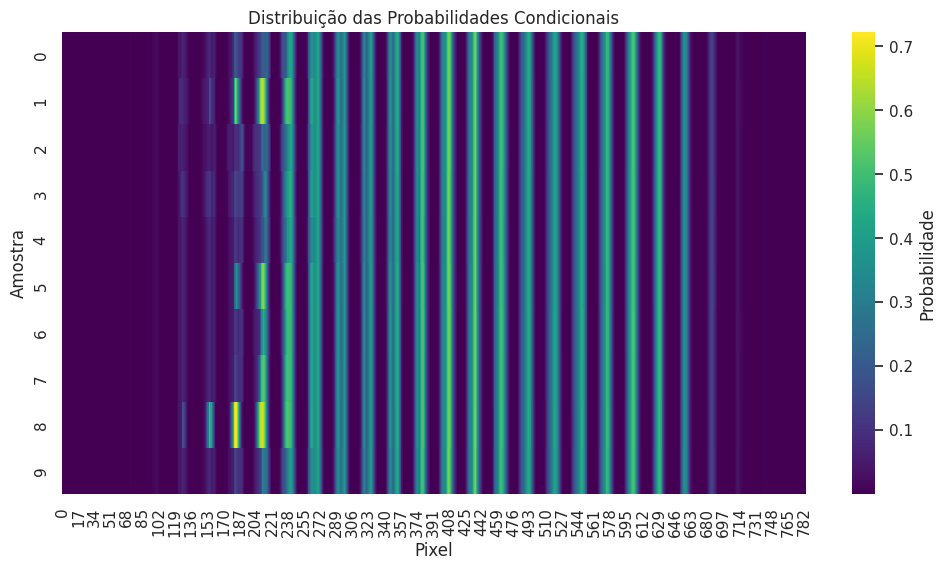

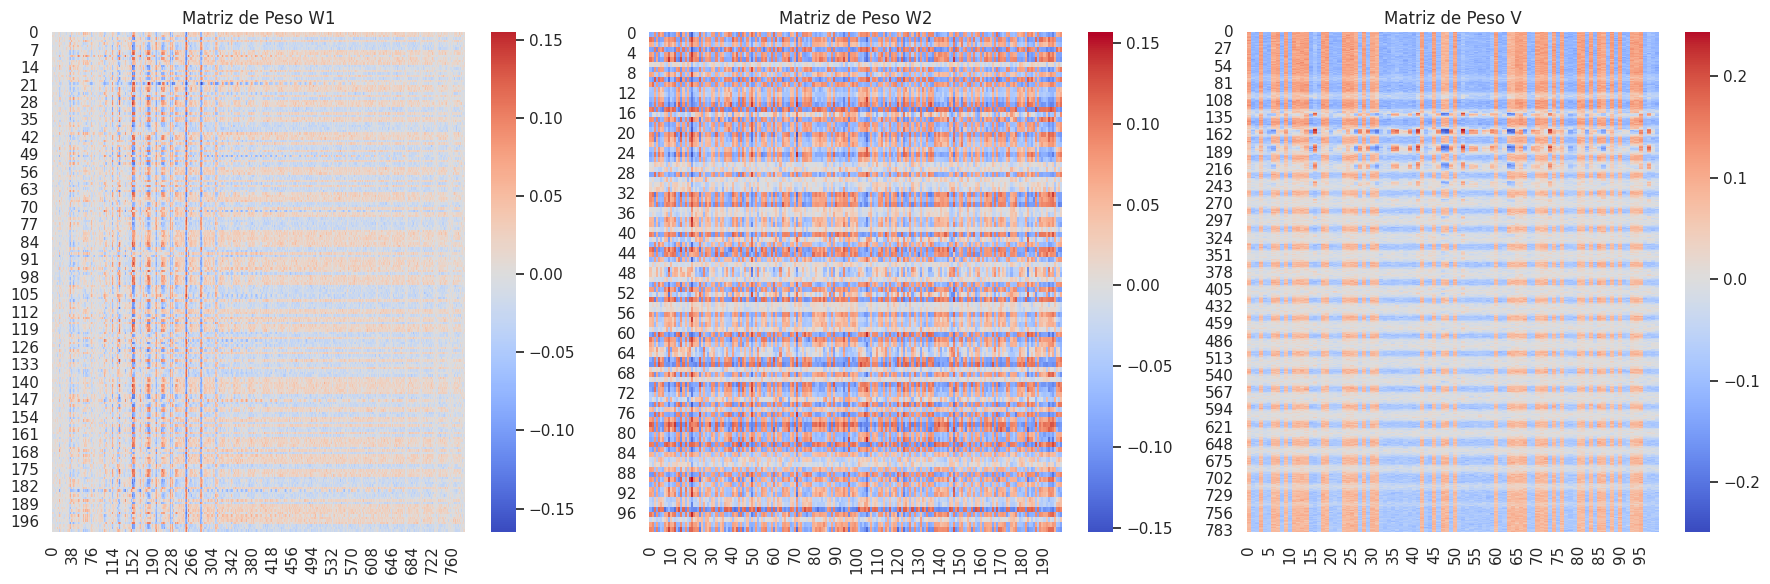

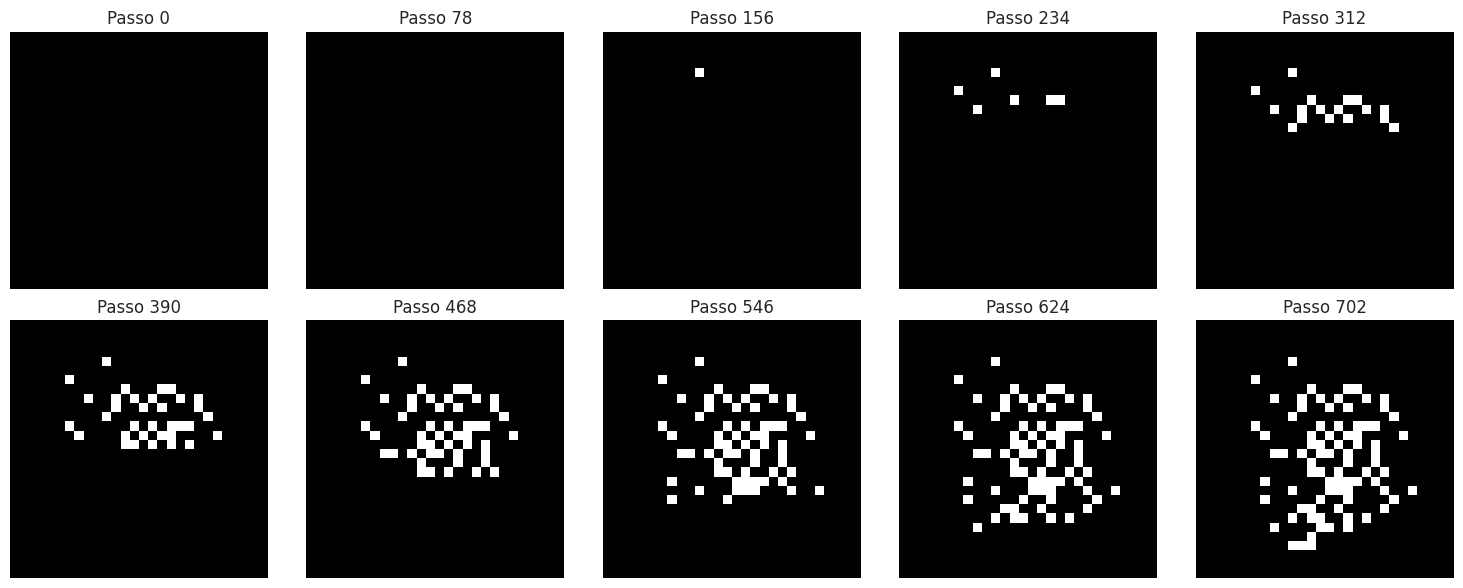

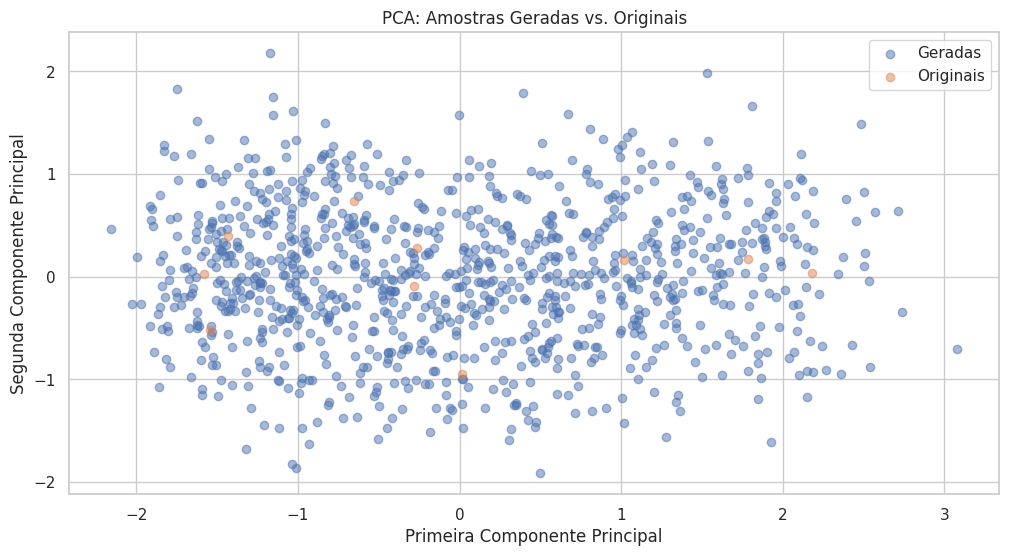

<ipython-input-3-e752bf20d15b>:84: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(generated_samples.flatten(), label='Geradas', shade=True)
<ipython-input-3-e752bf20d15b>:85: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original_samples.flatten(), label='Originais', shade=True)


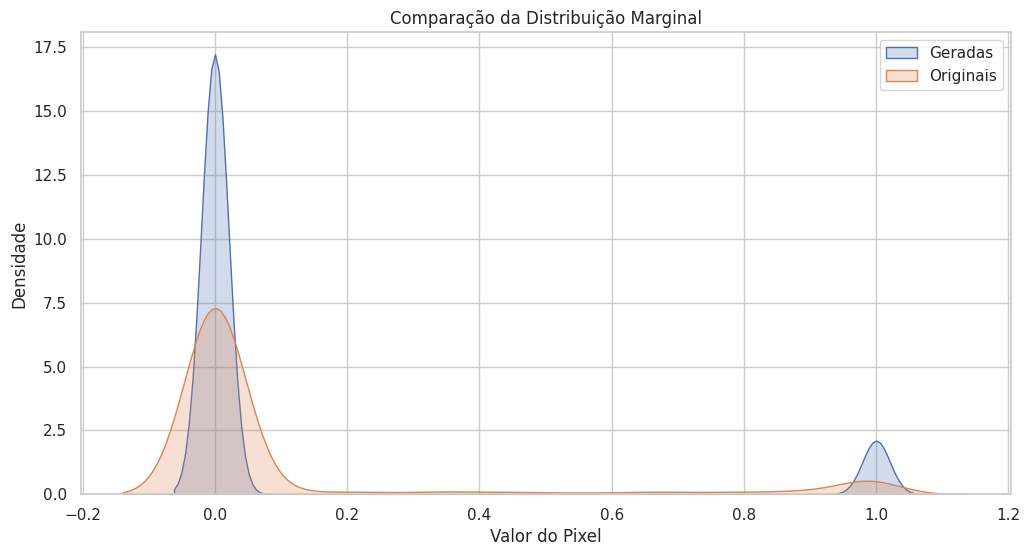

Visualizações adicionais concluídas.


In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

def plot_conditional_probabilities(model, num_samples=1000):
    samples = torch.tensor(model.sample(num_samples), dtype=torch.float32).to(device)
    probs = []

    for i in range(model.input_dim):
        h1 = torch.tanh(torch.mm(samples[:, :i], model.W1[:, :i].t()) + model.b1)
        h2 = torch.tanh(torch.mm(h1, model.W2.t()) + model.b2)
        o = torch.sigmoid(torch.mm(h2, model.V[i, :].unsqueeze(1)) + model.c[i]).squeeze()
        probs.append(o.cpu().detach().numpy())

    probs = np.array(probs).T

    plt.figure(figsize=(12, 6))
    sns.heatmap(probs[:10], cmap='viridis', cbar_kws={'label': 'Probabilidade'})
    plt.title('Distribuição das Probabilidades Condicionais')
    plt.xlabel('Pixel')
    plt.ylabel('Amostra')
    plt.show()

# Função para visualizar as matrizes de peso
def plot_weight_matrices(model):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    sns.heatmap(model.W1.cpu().detach().numpy(), ax=axes[0], cmap='coolwarm', center=0)
    axes[0].set_title('Matriz de Peso W1')

    sns.heatmap(model.W2.cpu().detach().numpy(), ax=axes[1], cmap='coolwarm', center=0)
    axes[1].set_title('Matriz de Peso W2')

    sns.heatmap(model.V.cpu().detach().numpy(), ax=axes[2], cmap='coolwarm', center=0)
    axes[2].set_title('Matriz de Peso V')

    plt.tight_layout()
    plt.show()

# Função para visualizar a reconstrução progressiva
def plot_progressive_reconstruction(model):
    sample = model.sample(1)[0]
    reconstructions = []

    for i in range(28*28):
        partial_sample = np.zeros_like(sample)
        partial_sample[:i+1] = sample[:i+1]
        reconstructions.append(partial_sample)

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, ax in enumerate(axes.flat):
        step = i * (28*28 // 10)
        ax.imshow(reconstructions[step].reshape(28, 28), cmap='gray')
        ax.set_title(f'Passo {step}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

def plot_pca_comparison(model, original_data):
    generated_samples = model.sample(1000)
    original_samples = original_data.reshape(-1, 28*28)[:1000]

    pca = PCA(n_components=2)
    generated_pca = pca.fit_transform(generated_samples)
    original_pca = pca.transform(original_samples)

    plt.figure(figsize=(12, 6))
    plt.scatter(generated_pca[:, 0], generated_pca[:, 1], alpha=0.5, label='Geradas')
    plt.scatter(original_pca[:, 0], original_pca[:, 1], alpha=0.5, label='Originais')
    plt.title('PCA: Amostras Geradas vs. Originais')
    plt.xlabel('Primeira Componente Principal')
    plt.ylabel('Segunda Componente Principal')
    plt.legend()
    plt.show()

def plot_marginal_distribution(model, original_data):
    generated_samples = model.sample(1000)
    original_samples = original_data.reshape(-1, 28*28)[:1000]

    plt.figure(figsize=(12, 6))
    sns.kdeplot(generated_samples.flatten(), label='Geradas', shade=True)
    sns.kdeplot(original_samples.flatten(), label='Originais', shade=True)
    plt.title('Comparação da Distribuição Marginal')
    plt.xlabel('Valor do Pixel')
    plt.ylabel('Densidade')
    plt.legend()
    plt.show()

# Gerar e plotar os novos gráficos
print("Gerando visualizações adicionais...")

plot_conditional_probabilities(nade_mnist)
plot_weight_matrices(nade_mnist)
plot_progressive_reconstruction(nade_mnist)
plot_pca_comparison(nade_mnist, original_images)
plot_marginal_distribution(nade_mnist, original_images)

print("Visualizações adicionais concluídas.")

<ipython-input-2-6ecc6a3e7521>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Usando dispositivo: cuda
Época [1/10], Perda: nan
Época [2/10], Perda: nan
Época [3/10], Perda: nan
Época [4/10], Perda: nan
Época [5/10], Perda: nan
Época [6/10], Perda: nan
Época [7/10], Perda: nan
Época [8/10], Perda: nan
Época [9/10], Perda: nan
Época [10/10], Perda: nan


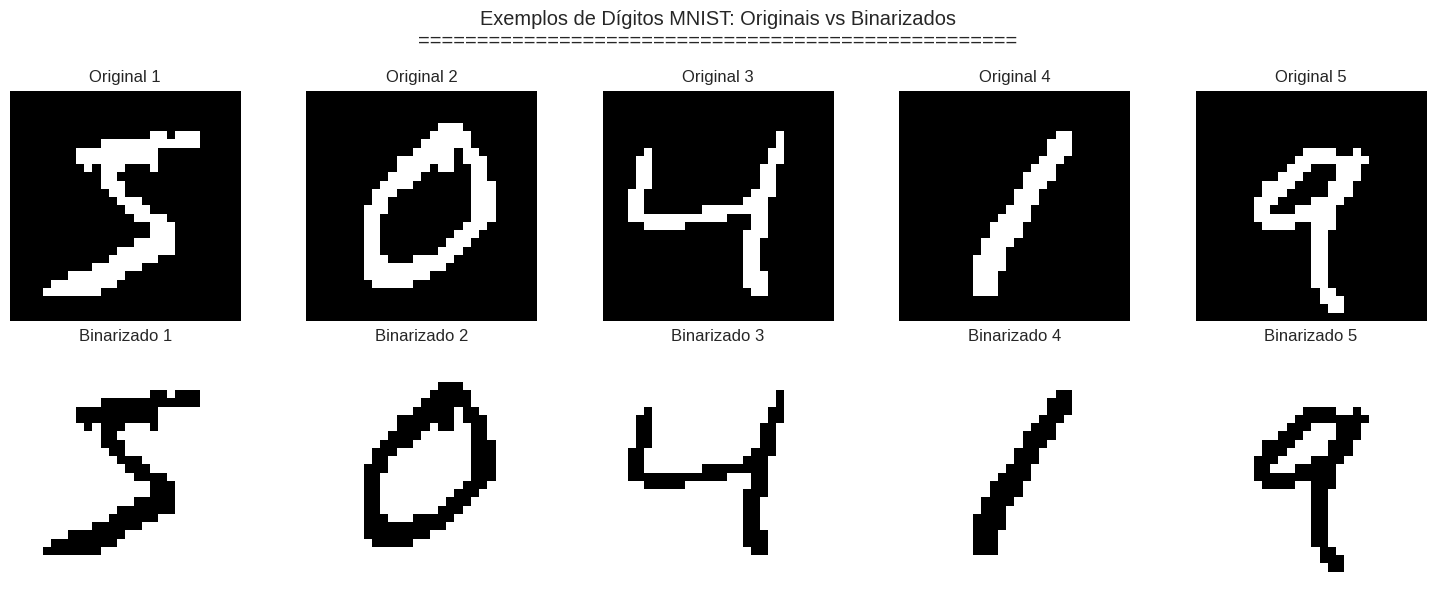

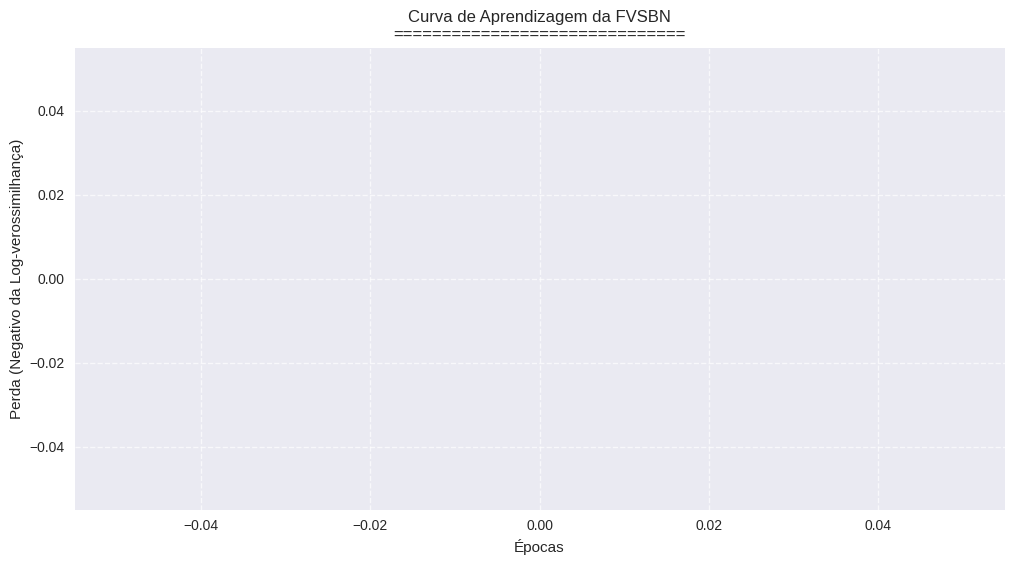

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from collections import Counter

# Configurações de estilo
plt.style.use('seaborn')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

# Verificar se GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Carregar dados MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float())  # Binarização
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024*5, shuffle=True)

# Implementação da FVSBN
class FVSBN(nn.Module):
    def __init__(self, n_variables):
        super(FVSBN, self).__init__()
        self.n_variables = n_variables
        self.alphas = nn.ParameterList([
            nn.Parameter(torch.randn(i, device=device)) for i in range(1, n_variables + 1)
        ])

    def forward(self, x):
        log_probs = []
        for i in range(self.n_variables):
            if i == 0:
                prob = torch.sigmoid(self.alphas[i])
            else:
                prob = torch.sigmoid(torch.sum(self.alphas[i][:i] * x[:, :i], dim=1))
            log_prob = torch.where(x[:, i] == 1, torch.log(prob), torch.log(1 - prob))
            log_probs.append(log_prob)
        return torch.sum(torch.stack(log_probs), dim=0)

    def sample(self, num_samples):
        samples = torch.zeros(num_samples, self.n_variables, device=device)
        for i in range(self.n_variables):
            if i == 0:
                prob = torch.sigmoid(self.alphas[i].expand(num_samples))
            else:
                prob = torch.sigmoid(torch.sum(self.alphas[i][:i].unsqueeze(0) * samples[:, :i], dim=1))
            samples[:, i] = torch.bernoulli(prob)
        return samples

# Função auxiliar para criar títulos mais descritivos
def create_title(title):
    return f"{title}\n{'=' * len(title)}"

# Inicializar e treinar o modelo
model = FVSBN(784).to(device)  # MNIST tem 28x28 = 784 pixels
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 10
losses = []

for epoch in range(epochs):
    epoch_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 784).to(device)
        optimizer.zero_grad()
        loss = -model(data).mean()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Época [{epoch+1}/{epochs}], Perda: {avg_loss:.4f}")

# Plot 1: Exemplos de dígitos originais e binarizados
fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle(create_title('Exemplos de Dígitos MNIST: Originais vs Binarizados'))

for i in range(5):
    img, _ = train_dataset[i]
    ax1[i].imshow(img.squeeze().numpy(), cmap='gray')
    ax1[i].axis('off')
    ax1[i].set_title(f'Original {i+1}')

    ax2[i].imshow(img.squeeze().numpy(), cmap='binary')
    ax2[i].axis('off')
    ax2[i].set_title(f'Binarizado {i+1}')

plt.tight_layout()
plt.show()

# Plot 2: Curva de aprendizagem
plt.figure(figsize=(12, 6))
plt.plot(losses, color='blue', alpha=0.7)
plt.title(create_title('Curva de Aprendizagem da FVSBN'))
plt.xlabel('Épocas')
plt.ylabel('Perda (Negativo da Log-verossimilhança)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Plot 3: Amostras geradas pelo modelo
num_samples = 25
with torch.no_grad():
    generated_samples = model.sample(num_samples).cpu().numpy().reshape(-1, 28, 28)

fig, axes = plt.subplots(5, 5, figsize=(12, 12))
fig.suptitle(create_title('Amostras Geradas pela FVSBN'))

for i, ax in enumerate(axes.flat):
    ax.imshow(generated_samples[i], cmap='binary')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Plot 4: Comparação da distribuição marginal
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

real_data = torch.cat([data.view(-1) for data, _ in train_loader]).cpu().numpy()
sns.histplot(real_data, ax=ax1, kde=True, stat="density", bins=2, color='blue', alpha=0.7)
ax1.axvline(real_data.mean(), color='r', linestyle='--', label=f'Média: {real_data.mean():.2f}')
ax1.set_title(create_title('Distribuição Marginal dos Pixels (Dados Reais)'))
ax1.set_xlabel('Valor do Pixel')
ax1.set_ylabel('Densidade')
ax1.legend()

generated_data = model.sample(10000).cpu().numpy().flatten()
sns.histplot(generated_data, ax=ax2, kde=True, stat="density", bins=2, color='green', alpha=0.7)
ax2.axvline(generated_data.mean(), color='r', linestyle='--', label=f'Média: {generated_data.mean():.2f}')
ax2.set_title(create_title('Distribuição Marginal dos Pixels (Amostras Geradas)'))
ax2.set_xlabel('Valor do Pixel')
ax2.set_ylabel('Densidade')
ax2.legend()

plt.tight_layout()
plt.show()

# Adicionar explicações textuais
print("Explicação dos gráficos:")
print("\n1. Exemplos de Dígitos MNIST:")
print("   - Mostra exemplos de dígitos MNIST originais e suas versões binarizadas.")
print("   - A binarização transforma os pixels em preto (0) ou branco (1) baseado em um limiar.")

print("\n2. Curva de Aprendizagem:")
print("   - Ilustra como a perda (negativo da log-verossimilhança) diminui ao longo das épocas de treinamento.")
print("   - Uma curva descendente indica que o modelo está aprendendo a distribuição dos dados MNIST.")

print("\n3. Amostras Geradas:")
print("   - Exibe dígitos gerados pelo modelo FVSBN após o treinamento.")
print("   - Quanto mais parecidos com dígitos reais, melhor o modelo capturou a distribuição dos dados.")

print("\n4. Distribuição Marginal:")
print("   - Compara a distribuição dos valores dos pixels nos dados reais (esquerda) com as amostras geradas (direita).")
print("   - As linhas verticais vermelhas mostram a média de cada distribuição.")
print("   - Distribuições similares indicam que o modelo está capturando bem as características globais dos dados.")